In [5]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline

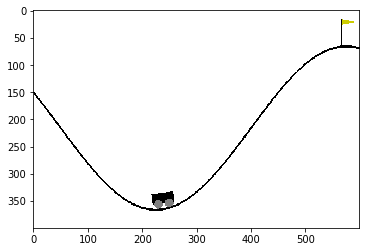

In [6]:
env = gym.make('MountainCar-v0')
env.reset()
plt.imshow(env.render('rgb_array'))
env.close()

In [7]:
env.action_space

Discrete(3)

In [8]:
env.observation_space


Box(2,)

In [9]:
env.spec.reward_threshold

-110.0

In [10]:
def policy(obs):
    # Write the code for your policy here. You can use the observation
    # (a tuple of position and velocity), the current time step, or both,
    # if you want.
    position, velocity = obs
    if velocity > 0:
      action = actions['right']
    elif velocity < 0:
      action = actions['left']
    else:
      action = actions['left']
    # This is an example policy. You can try running it, but it will not work.
    # Your goal is to fix that.
    return action

In [11]:
env = gym.make('MountainCar-v0')
env =  gym.wrappers.Monitor(env, './video/', force=True)
s = env.reset()
actions = {'left': 0, 'stop': 1, 'right': 2}

for i in range(1000):
    
    a = policy(s)
    obs, r, done, info = env.step(a)
    s = obs
    
    if done:
        break
env.close()

# Frozen Lake

In [12]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys
env = gym.make('FrozenLake-v0').env
sys.stdout = open("example.txt", 'w+')
env.render()
env.close()

In [13]:
env.action_space, env.observation_space, env.metadata, env.reward_range, env.spec.reward_threshold

(Discrete(4), Discrete(16), {'render.modes': ['human', 'ansi']}, (0, 1), 0.78)

In [14]:
env.action_space.n, env.observation_space.dtype

(4, dtype('int64'))

In [15]:
def generate_session(env, policy, t_max=10000):
    
    actions = []
    states = []
    reward = 0
    
    s = env.reset()
    
    for i in range(t_max):
        
        a = np.random.choice(range(env.action_space.n), p=policy[s, :])
        new_s, r, done, info  = env.step(a)
        
        actions.append(a)
        states.append(s)
        reward += r
        s = new_s
        
        if done:
            break
            
    return actions, states, reward

In [16]:
def update_policy(actions, states):
    
    policy_mat = np.zeros((env.observation_space.n, env.action_space.n))
    for i, j in zip(actions, states):
        policy_mat[j, i] +=1
    idx_not_visited = np.argwhere(policy_mat.sum(axis=1) == 0)
    policy_mat[idx_not_visited, :] = 1/env.action_space.n
    policy_mat = policy_mat/policy_mat.sum(axis=1)[:, np.newaxis]
    return policy_mat

In [1]:
def select_elite(states, actions, rewards, percentile=50):
    
    threshold = np.percentile(rewards, percentile)
    elite_states = sum([state for reward, state in zip( rewards, states) if reward > threshold], [])
    elite_actions = sum([action for reward, action in zip( rewards, actions) if reward > threshold], [])
    return elite_states, elite_actions

In [2]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.savefig("frozen_progress.png")
    plt.show()

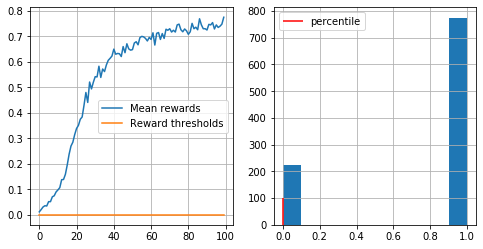

In [8]:
percentile = 10
steps_session = 20000
n_sessions = 1000
total_steps = 100
learning_rate= 0.6

env = gym.make('FrozenLake-v0').env
policy = np.ones((env.observation_space.n, env.action_space.n))/env.action_space.n

log = []

for i in range(total_steps):
    
    sessions = [generate_session(env, policy, steps_session) for j in range(n_sessions)]
    
    actions, states, rewards = zip(*sessions)
    
    elite_states, elite_actions = select_elite(states, actions, rewards, percentile)
    
    new_policy = update_policy(elite_actions, elite_states)
    
    policy = learning_rate*new_policy + (1-learning_rate)*policy
    
    show_progress(rewards, log, percentile, reward_range=[0, 1])



In [18]:
import pickle
with open("policy.pkl", "wb") as file:
    pickle.dump(policy, file)

In [ ]:
env = gym.make('FrozenLake-v0').env
env =  gym.wrappers.Monitor(env, './video/', force=True,)
s = env.reset()

for i in range(1000):
    
    a = np.random.choice(range(env.action_space.n), p=policy[s, :])
    obs, r, done, info = env.step(a)
    s = obs
    if done:
        break
env.close()



In [ ]:
env.render()

# Lunar Lander

In [21]:
import gym
from sklearn import neural_network
from joblib import delayed, Parallel
from multiprocessing import cpu_count

In [22]:
env = gym.make('LunarLander-v2').env
env.render()


True

In [23]:
env.close()

In [24]:
env.action_space, env.game_over, env.continuous, env.helipad_x1, env.observation_space, env.reward_range, env.spec.reward_threshold

(Discrete(4), False, False, 8.0, Box(8,), (-inf, inf), 200)

In [32]:
env.observation_space.

(8,)

In [40]:
n_actions = env.action_space.n

In [51]:
def generate_session(env, agent, t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        probs = agent.predict_proba(s.reshape(1, -1)).squeeze()#<YOUR CODE>
        a = np.random.choice(range(n_actions), size=None, p=probs) #<YOUR CODE>
        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return actions, states, total_reward

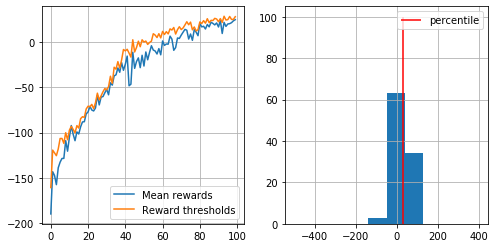

In [55]:
percentile = 50
steps_session = 2000
n_sessions = 100
total_steps = 100

env = gym.make('LunarLander-v2').env
mlp = neural_network.MLPClassifier((128, 64), activation='tanh', learning_rate_init=0.001)
mlp.partial_fit([env.reset()]*n_actions, range(n_actions), range(n_actions))
log = []

for i in range(total_steps):
    
    sessions = Parallel(n_jobs=cpu_count())(delayed(generate_session)(env, mlp, steps_session) for j in range(n_sessions))
    actions, states, rewards = zip(*sessions)
    
    elite_states, elite_actions = select_elite(states, actions, rewards, percentile)
    mlp.partial_fit(elite_states, np.asarray(elite_actions).reshape(-1, 1))
    
    show_progress(rewards, log, percentile, reward_range=[-500, 400])


In [56]:
env = gym.make('LunarLander-v2')
env =  gym.wrappers.Monitor(env, './video_lander/', force=True)
s = env.reset()

for i in range(1000):
    
    probs = mlp.predict_proba(s.reshape(1, -1)).squeeze()#<YOUR CODE>
    a = np.random.choice(range(n_actions), size=None, p=probs) #<YOUR CODE>
    obs, r, done, info = env.step(a)
    s = obs
    
    if done:
        break
env.close()

In [61]:
env = gym.make('LunarLander-v2')
env =  gym.wrappers.Monitor(env, './video_landerr_bad/', force=True)
s = env.reset()

for i in range(1000):

    a = env.action_space.sample()
    obs, r, done, info = env.step(a)
    s = obs
    
    if done:
        break
env.close()